In [1]:
import os
import pickle
import numpy as np

# Path to your dataset
DATASET_PATH = r"C:\Users\Ajayj\Documents\ResearchData\PPG_Data\PPG_FieldStudy"

def load_ppg_dataset(dataset_path):
    """
    Load synchronized PPG dataset from all subject .pkl files.
    
    Returns:
        dataset (dict): 
            {
              "S1": {"BVP": np.array, "ACC": np.array, "HR": np.array, "Activity": np.array},
              "S2": {...},
              ...
            }
    """
    dataset = {}
    
    for subj in range(1, 16):  # Subjects S1 ... S15
        subj_id = f"S{subj}"
        subj_folder = os.path.join(dataset_path, subj_id)
        pkl_file = os.path.join(subj_folder, f"{subj_id}.pkl")
        
        if not os.path.exists(pkl_file):
            print(f"⚠️ Missing file: {pkl_file}")
            continue
        
        # Load the .pkl file
        with open(pkl_file, "rb") as f:
            data = pickle.load(f, encoding="latin1")  # latin1 ensures compatibility
        
        # Extract signals + labels
        bvp = np.array(data["signal"]["wrist"]["BVP"])   # 64 Hz PPG
        acc = np.array(data["signal"]["wrist"]["ACC"])   # 32 Hz ACC (3D)
        hr  = np.array(data["label"])                    # ECG-derived HR (windowed)
        act = np.array(data["activity"])                 # Activity ID
        
        dataset[subj_id] = {
            "BVP": bvp,
            "ACC": acc,
            "HR": hr,
            "Activity": act
        }
        
        print(f"✅ Loaded {subj_id}: BVP {bvp.shape}, ACC {acc.shape}, HR {hr.shape}, Activity {act.shape}")
    
    return dataset

# Run loader
dataset = load_ppg_dataset(DATASET_PATH)

# Example: check S1 keys
print("\nKeys for S1:", dataset["S1"].keys())


✅ Loaded S1: BVP (589568, 1), ACC (294784, 3), HR (4603,), Activity (36848, 1)
✅ Loaded S2: BVP (525120, 1), ACC (262560, 3), HR (4099,), Activity (32820, 1)
✅ Loaded S3: BVP (559424, 1), ACC (279712, 3), HR (4367,), Activity (34964, 1)
✅ Loaded S4: BVP (585600, 1), ACC (292800, 3), HR (4572,), Activity (36600, 1)
✅ Loaded S5: BVP (595520, 1), ACC (297760, 3), HR (4649,), Activity (37220, 1)
✅ Loaded S6: BVP (336000, 1), ACC (168000, 3), HR (2622,), Activity (21000, 1)
✅ Loaded S7: BVP (597952, 1), ACC (298976, 3), HR (4668,), Activity (37372, 1)
✅ Loaded S8: BVP (517120, 1), ACC (258560, 3), HR (4037,), Activity (32320, 1)
✅ Loaded S9: BVP (547840, 1), ACC (273920, 3), HR (4277,), Activity (34240, 1)
✅ Loaded S10: BVP (681472, 1), ACC (340736, 3), HR (5321,), Activity (42592, 1)
✅ Loaded S11: BVP (579072, 1), ACC (289536, 3), HR (4521,), Activity (36192, 1)
✅ Loaded S12: BVP (506496, 1), ACC (253248, 3), HR (3954,), Activity (31656, 1)
✅ Loaded S13: BVP (584704, 1), ACC (292352, 3), H

In [2]:
import numpy as np

def segment_signal(signal, window_size, step_size):
    """
    Segment 1D or 2D signal into overlapping windows.
    
    Args:
        signal (np.array): shape (N,) or (N, D)
        window_size (int): number of samples per window
        step_size (int): number of samples to move the window
    
    Returns:
        windows (np.array): shape (#windows, window_size, D)
    """
    n_samples = signal.shape[0]
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    n_dims = signal.shape[1]
    
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(signal[start:end])
    return np.array(windows)

def preprocess_dataset(dataset):
    """
    For each subject, segment BVP and ACC signals into 8s windows
    with 2s shift and align them with HR labels.
    
    Returns:
        processed (dict): {subject: {"BVP": ..., "ACC": ..., "HR": ..., "Activity": ...}}
    """
    processed = {}
    
    # Parameters
    bvp_fs = 64   # Hz
    acc_fs = 32   # Hz
    win_time = 8  # seconds
    step_time = 2 # seconds
    
    bvp_win = win_time * bvp_fs   # 512 samples
    bvp_step = step_time * bvp_fs # 128 samples
    
    acc_win = win_time * acc_fs   # 256 samples
    acc_step = step_time * acc_fs # 64 samples
    
    for subj, data in dataset.items():
        bvp = data["BVP"].squeeze()    # (N,)
        acc = data["ACC"]              # (N, 3)
        hr  = data["HR"]               # (#windows,)
        act = data["Activity"]         # (#activity_samples, 1) at 4 Hz
        
        # Segment BVP + ACC
        bvp_windows = segment_signal(bvp, bvp_win, bvp_step)
        acc_windows = segment_signal(acc, acc_win, acc_step)
        
        # Align to HR length
        min_len = min(len(hr), len(bvp_windows), len(acc_windows))
        bvp_windows = bvp_windows[:min_len]
        acc_windows = acc_windows[:min_len]
        hr = hr[:min_len]
        
        processed[subj] = {
            "BVP": bvp_windows,   # (N_windows, 512, 1)
            "ACC": acc_windows,   # (N_windows, 256, 3)
            "HR": hr,             # (N_windows,)
            "Activity": act       # Keep raw activity for now
        }
        
        print(f"✅ {subj}: {bvp_windows.shape}, {acc_windows.shape}, HR {hr.shape}")
    
    return processed

# Run preprocessing
processed_dataset = preprocess_dataset(dataset)

# Example check
print("\nS1 processed shapes:")
print("BVP:", processed_dataset["S1"]["BVP"].shape)
print("ACC:", processed_dataset["S1"]["ACC"].shape)
print("HR:", processed_dataset["S1"]["HR"].shape)


✅ S1: (4603, 512, 1), (4603, 256, 3), HR (4603,)
✅ S2: (4099, 512, 1), (4099, 256, 3), HR (4099,)
✅ S3: (4367, 512, 1), (4367, 256, 3), HR (4367,)
✅ S4: (4572, 512, 1), (4572, 256, 3), HR (4572,)
✅ S5: (4649, 512, 1), (4649, 256, 3), HR (4649,)
✅ S6: (2622, 512, 1), (2622, 256, 3), HR (2622,)
✅ S7: (4668, 512, 1), (4668, 256, 3), HR (4668,)
✅ S8: (4037, 512, 1), (4037, 256, 3), HR (4037,)
✅ S9: (4277, 512, 1), (4277, 256, 3), HR (4277,)
✅ S10: (5321, 512, 1), (5321, 256, 3), HR (5321,)
✅ S11: (4521, 512, 1), (4521, 256, 3), HR (4521,)
✅ S12: (3954, 512, 1), (3954, 256, 3), HR (3954,)
✅ S13: (4565, 512, 1), (4565, 256, 3), HR (4565,)
✅ S14: (4476, 512, 1), (4476, 256, 3), HR (4476,)
✅ S15: (3966, 512, 1), (3966, 256, 3), HR (3966,)

S1 processed shapes:
BVP: (4603, 512, 1)
ACC: (4603, 256, 3)
HR: (4603,)


In [3]:
import numpy as np
import scipy.stats as stats
from scipy.signal import welch

def extract_bvp_features(window, fs=64):
    """Extract time + frequency features from one BVP window (512 samples)."""
    feats = []
    
    # Time-domain
    feats.append(np.mean(window))
    feats.append(np.std(window))
    feats.append(np.min(window))
    feats.append(np.max(window))
    feats.append(stats.skew(window))
    feats.append(stats.kurtosis(window))
    
    # Frequency-domain (Welch PSD)
    freqs, psd = welch(window, fs=fs, nperseg=256)
    
    # Bands: low freq (0.04-0.15 Hz), high freq (0.15-0.4 Hz)
    lf_band = np.logical_and(freqs >= 0.04, freqs < 0.15)
    hf_band = np.logical_and(freqs >= 0.15, freqs < 0.4)
    
    lf_power = np.sum(psd[lf_band])
    hf_power = np.sum(psd[hf_band])
    
    feats.append(lf_power)
    feats.append(hf_power)
    
    # Dominant frequency
    dom_idx = np.argmax(psd)
    feats.append(freqs[dom_idx])
    feats.append(psd[dom_idx])
    
    return np.array(feats)

def safe_corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0,1]

def extract_acc_features(window, fs=32):
    """Extract motion features from one ACC window (256×3)."""
    feats = []
    for i in range(3):  # x, y, z axes
        axis = window[:, i]
        feats.append(np.mean(axis))
        feats.append(np.std(axis))
        feats.append(np.min(axis))
        feats.append(np.max(axis))
        feats.append(np.sum(axis**2))  # energy
    
    # Cross-axis correlations
    feats.append(safe_corrcoef(window[:,0], window[:,1]))
    feats.append(safe_corrcoef(window[:,0], window[:,2]))
    feats.append(safe_corrcoef(window[:,1], window[:,2]))
    
    return np.array(feats)

def build_feature_dataset(processed_dataset):
    """
    Extract features from BVP + ACC for all subjects.
    Returns:
        X (np.array): features [N_windows, N_features]
        y (np.array): HR labels [N_windows]
        subjects (list): subject IDs per window
    """
    X, y, subjects = [], [], []
    
    for subj, data in processed_dataset.items():
        bvp_windows = data["BVP"]
        acc_windows = data["ACC"]
        hr_labels = data["HR"]
        
        for i in range(len(hr_labels)):
            bvp_feats = extract_bvp_features(bvp_windows[i].squeeze())
            acc_feats = extract_acc_features(acc_windows[i])
            feats = np.concatenate([bvp_feats, acc_feats])
            
            X.append(feats)
            y.append(hr_labels[i])
            subjects.append(subj)
    
    return np.array(X), np.array(y), subjects

# Run feature extraction
X, y, subj_ids = build_feature_dataset(processed_dataset)

print("Feature dataset shape:", X.shape)
print("Labels shape:", y.shape)
print("Example feature vector length:", X.shape[1])


Feature dataset shape: (64697, 28)
Labels shape: (64697,)
Example feature vector length: 28


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_train_test(X, y, test_size=0.2, random_state=42):
    """
    Normalize features and split into train/test sets.
    """
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state
    )
    
    print("Train set:", X_train.shape, "Test set:", X_test.shape)
    return X_train, X_test, y_train, y_test, scaler

# Run preparation
X_train, X_test, y_train, y_test, scaler = prepare_train_test(X, y)

print("✅ Dataset ready for modeling")


Train set: (51757, 28) Test set: (12940, 28)
✅ Dataset ready for modeling


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train a Random Forest Regressor for HR prediction.
    """
    model = RandomForestRegressor(
        n_estimators=200,   # number of trees
        max_depth=15,       # prevent overfitting
        random_state=42,
        n_jobs=-1           # use all cores
    )
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("✅ Model trained")
    print(f"MAE: {mae:.2f} bpm")
    print(f"RMSE: {rmse:.2f} bpm")
    print(f"R²: {r2:.3f}")
    
    return model, y_pred

# Run training
rf_model, y_pred = train_random_forest(X_train, y_train, X_test, y_test)


✅ Model trained
MAE: 7.05 bpm
RMSE: 10.71 bpm
R²: 0.776


In [6]:
from sklearn.model_selection import GridSearchCV, KFold

def tune_random_forest(X_train, y_train):
    """
    Grid search hyperparameter tuning for Random Forest.
    """
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 15, 20],
        "min_samples_split": [2, 5, 10]
    }
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=KFold(n_splits=3, shuffle=True, random_state=42),
        scoring="neg_mean_absolute_error",
        verbose=2,
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    print("✅ Best parameters:", grid.best_params_)
    print("Best CV score (MAE):", -grid.best_score_)
    
    return grid.best_estimator_

# Run tuning (⚠️ may take longer)
best_rf = tune_random_forest(X_train, y_train)

# Evaluate tuned model
y_pred_best = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("\n📊 Tuned Random Forest Performance")
print(f"MAE: {mae:.2f} bpm")
print(f"RMSE: {rmse:.2f} bpm")
print(f"R²: {r2:.3f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
✅ Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score (MAE): 6.911044325040212

📊 Tuned Random Forest Performance
MAE: 6.43 bpm
RMSE: 9.98 bpm
R²: 0.806


Note: you may need to restart the kernel to use updated packages.


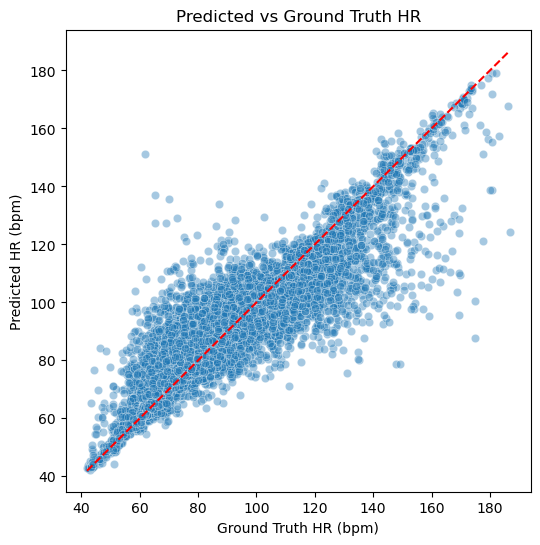

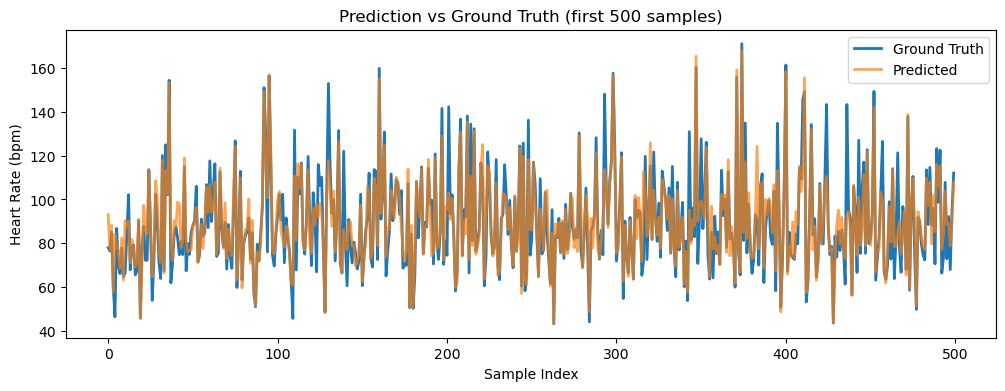

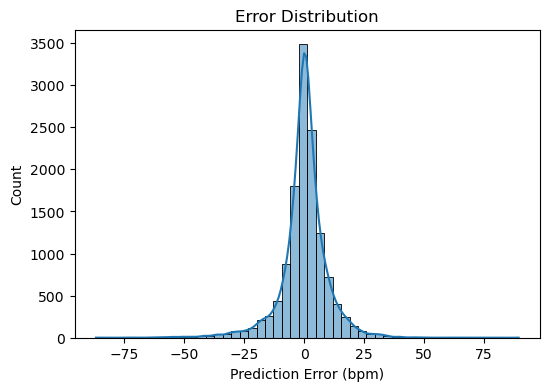

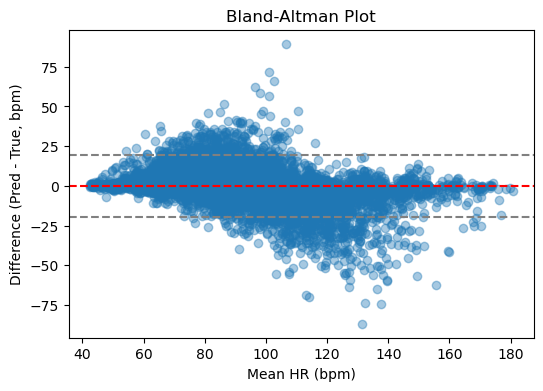

In [7]:
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_test, y_pred, sample_range=500):
    # 1. Scatter Plot
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Ground Truth HR (bpm)")
    plt.ylabel("Predicted HR (bpm)")
    plt.title("Predicted vs Ground Truth HR")
    plt.show()
    
    # 2. Time Series (first N samples)
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:sample_range], label="Ground Truth", lw=2)
    plt.plot(y_pred[:sample_range], label="Predicted", lw=2, alpha=0.7)
    plt.xlabel("Sample Index")
    plt.ylabel("Heart Rate (bpm)")
    plt.title(f"Prediction vs Ground Truth (first {sample_range} samples)")
    plt.legend()
    plt.show()
    
    # 3. Error Distribution
    errors = y_pred - y_test
    plt.figure(figsize=(6,4))
    sns.histplot(errors, bins=50, kde=True)
    plt.xlabel("Prediction Error (bpm)")
    plt.title("Error Distribution")
    plt.show()
    
    # 4. Bland-Altman Plot (optional)
    mean_hr = (y_test + y_pred) / 2
    diff_hr = y_pred - y_test
    plt.figure(figsize=(6,4))
    plt.scatter(mean_hr, diff_hr, alpha=0.4)
    plt.axhline(np.mean(diff_hr), color='red', linestyle='--')
    plt.axhline(np.mean(diff_hr) + 1.96*np.std(diff_hr), color='gray', linestyle='--')
    plt.axhline(np.mean(diff_hr) - 1.96*np.std(diff_hr), color='gray', linestyle='--')
    plt.xlabel("Mean HR (bpm)")
    plt.ylabel("Difference (Pred - True, bpm)")
    plt.title("Bland-Altman Plot")
    plt.show()

# Run evaluation
evaluate_model(y_test, y_pred_best)


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import glob
# -------------------------
# Step 1: Single Subject Prediction
# -------------------------
def predict_from_subject(pkl_path, model_path="rf_hr_model.pkl", scaler_path="scaler.pkl"):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")
    
    # Segment signals
    bvp_windows = segment_signal(data["signal"]["wrist"]["BVP"].squeeze(), 512, 128)
    acc_windows = segment_signal(data["signal"]["wrist"]["ACC"], 256, 64)
    hr_labels = np.array(data["label"])
    
    # Align
    min_len = min(len(hr_labels), len(bvp_windows), len(acc_windows))
    bvp_windows, acc_windows, hr_labels = bvp_windows[:min_len], acc_windows[:min_len], hr_labels[:min_len]
    
    # Feature extraction
    feats = []
    for i in range(min_len):
        bvp_feats = extract_bvp_features(bvp_windows[i].squeeze())
        acc_feats = extract_acc_features(acc_windows[i])
        feats.append(np.concatenate([bvp_feats, acc_feats]))
    
    X_new = np.array(feats)
    X_new_scaled = scaler.transform(X_new)
    
    y_pred = model.predict(X_new_scaled)
    return hr_labels, y_pred

# -------------------------
# Step 2: Batch Evaluation
# -------------------------
def evaluate_all_subjects(base_path, model_path="rf_hr_model.pkl", scaler_path="scaler.pkl"):
    results = []
    for subj in range(1, 16):
        subj_id = f"S{subj}"
        pkl_path = os.path.join(base_path, subj_id, f"{subj_id}.pkl")
        if not os.path.exists(pkl_path):
            continue
        y_true, y_pred = predict_from_subject(pkl_path, model_path, scaler_path)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        results.append([subj_id, mae, rmse, r2])
    return pd.DataFrame(results, columns=["Subject", "MAE", "RMSE", "R2"])

def add_overall_metrics(results_df, base_path, model_path="rf_hr_model.pkl", scaler_path="scaler.pkl"):
    all_true, all_pred = [], []
    for subj in results_df["Subject"]:
        pkl_path = os.path.join(base_path, subj, f"{subj}.pkl")
        y_true, y_pred = predict_from_subject(pkl_path, model_path, scaler_path)
        all_true.extend(y_true)
        all_pred.extend(y_pred)
    overall = pd.DataFrame([["Overall",
                             mean_absolute_error(all_true, all_pred),
                             np.sqrt(mean_squared_error(all_true, all_pred)),
                             r2_score(all_true, all_pred)]],
                           columns=["Subject", "MAE", "RMSE", "R2"])
    return pd.concat([results_df, overall], ignore_index=True)


✅ Subject Classification Model Trained

              precision    recall  f1-score   support

          S1       0.87      0.83      0.85       921
         S10       0.81      0.85      0.83      1064
         S11       0.85      0.83      0.84       904
         S12       0.90      0.88      0.89       791
         S13       0.83      0.86      0.84       913
         S14       0.92      0.88      0.90       895
         S15       0.85      0.86      0.86       793
          S2       0.84      0.89      0.86       820
          S3       0.88      0.82      0.85       874
          S4       0.82      0.80      0.81       915
          S5       0.81      0.94      0.87       930
          S6       0.91      0.74      0.82       524
          S7       0.87      0.86      0.87       934
          S8       0.90      0.91      0.90       807
          S9       0.81      0.83      0.82       855

    accuracy                           0.85     12940
   macro avg       0.86      0.85      0

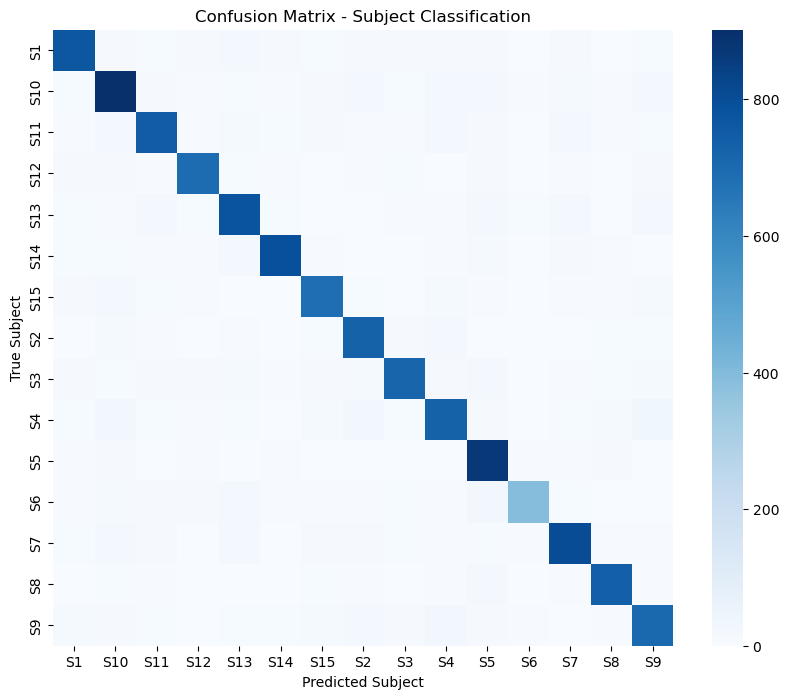

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def prepare_classification_dataset(processed_dataset):
    """
    Build dataset for subject classification.
    Each window's features -> subject ID label.
    """
    X, y = [], []
    
    for subj, data in processed_dataset.items():
        bvp_windows = data["BVP"]
        acc_windows = data["ACC"]
        
        for i in range(len(bvp_windows)):
            bvp_feats = extract_bvp_features(bvp_windows[i].squeeze())
            acc_feats = extract_acc_features(acc_windows[i])
            feats = np.concatenate([bvp_feats, acc_feats])
            
            X.append(feats)
            y.append(subj)  # subject ID label
    
    return np.array(X), np.array(y)

# Build dataset
X_subj, y_subj = prepare_classification_dataset(processed_dataset)

# Encode subject labels (S1..S15 -> 0..14)
encoder = LabelEncoder()
y_subj_encoded = encoder.fit_transform(y_subj)

# Split train/test
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_subj, y_subj_encoded, test_size=0.2, random_state=42, stratify=y_subj_encoded
)

# Train Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=300, max_depth=20, random_state=42, n_jobs=-1
)
clf.fit(X_train_s, y_train_s)

# Predictions
y_pred_s = clf.predict(X_test_s)

# Evaluation
print("✅ Subject Classification Model Trained\n")
print(classification_report(y_test_s, y_pred_s, target_names=encoder.classes_))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_s, y_pred_s)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Subject")
plt.ylabel("True Subject")
plt.title("Confusion Matrix - Subject Classification")
plt.show()
